## Importing Required Libraries and Setting Up Environment

In this section, I imported all the necessary libraries used throughout the project. These include:
- **NumPy and Pandas** for data manipulation,
- **Matplotlib and Seaborn** for data visualization,
- **SimpleITK and PIL** for medical image processing,
- **TensorFlow and Keras** for building the deep learning model,
- **scikit-learn** for evaluation metrics and dataset splitting,
- **tqdm** for progress visualization.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import SimpleITK as sitk
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from tqdm.notebook import tqdm

In [5]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Loading and Preparing the Dataset

Here, I loaded the candidate dataset which contains information about lung nodules and their labels (`class`: 1 for malignant, 0 for benign).

In [6]:
# Load datasets
candidates = pd.read_csv('../src/data/candidates.csv')
print(f"Total samples in dataset: {len(candidates)}")

Total samples in dataset: 551065


Since the dataset is highly imbalanced, I created a balanced dataset using a 1:2 ratio of positives (malignant) to negatives (benign). This helps prevent the model from being biased toward the majority class.

In [7]:
# Balance classes
positives = candidates[candidates['class'] == 1]
negatives = candidates[candidates['class'] == 0]
print(f"Positive samples: {len(positives)}, Negative samples: {len(negatives)}")

neg_sample = negatives.sample(n = len(positives) * 2, random_state = 42)
balanced_df = pd.concat([positives, neg_sample]).sample(frac = 1, random_state = 42)
print(f"Balanced dataset created with {len(balanced_df)} samples.")

Positive samples: 1351, Negative samples: 549714
Balanced dataset created with 4053 samples.


After balancing, I split the data into:
- **Training set (70%)**
- **Validation set (15%)**
- **Test set (15%)**

I used stratified splitting to maintain the class distribution across all subsets and ensure fair evaluation.

In [8]:
# Split data
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = 42)

print(f"Training set: {len(X_train)} | Validation set: {len(X_val)} | Test set: {len(X_test)}")

Training set: 2837 | Validation set: 608 | Test set: 608


## Loading and Processing CT Scan Images

This custom `CTScan` class is designed to handle `.mhd` files from the LUNA16 dataset, which represent 3D CT scan volumes.

### Key Responsibilities:
- **`read_mhd_image()`**: Loads the `.mhd` image using `SimpleITK`.
- **`get_voxel_coords()`**: Converts world coordinates to voxel coordinates for accurate nodule localization.
- **`get_subimage()`**: Extracts a 2D slice (centered at the nodule) from the 3D scan.
- **`normalize_planes()`**: Normalizes pixel values to the 0–1 range based on Hounsfield units (minHU = -1000, maxHU = 400).
- **`save_image()`**: Saves the normalized subimage as a grayscale `.png` image for training.

By encapsulating this logic inside a class, I made the image preprocessing modular and reusable.

In [9]:
class CTScan:
    def __init__(self, filename=None, coords=None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None
        self.read_mhd_image()

    def read_mhd_image(self):
        try:
            path = glob.glob(os.path.join('../src/data/raw/**', self.filename + '.mhd'))[0]
            self.ds = sitk.ReadImage(path)
            self.image = sitk.GetArrayFromImage(self.ds)
        except Exception as e:
            print(f"Error loading {self.filename}: {str(e)}")
            raise

    def get_voxel_coords(self):
        origin = self.ds.GetOrigin()
        resolution = self.ds.GetSpacing()
        voxel_coords = [abs(self.coords[j] - origin[j]) / resolution[j] for j in range(3)]
        return tuple(map(int, voxel_coords))

    def get_subimage(self, width=50):
        x, y, z = self.get_voxel_coords()
        half = width // 2
        return self.image[z, y-half:y+half, x-half:x+half]

    def normalize_planes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        return np.clip(npzarray, 0, 1)

    def save_image(self, filename, width=50):
        subimage = self.get_subimage(width)
        subimage = self.normalize_planes(subimage)
        subimage = (subimage * 255).astype(np.uint8)
        Image.fromarray(subimage).convert('L').save(filename)

After defining the `CTScan` class, I used it here to process and save the images for each data split. For every row in the dataset (which includes the series UID and nodule coordinates), the script extracts a centered 2D slice, normalizes it, and saves it as a `.jpg`.

This process ensures that my training, validation, and test datasets are properly prepared as image inputs for the CNN model.

In [10]:
def save_dataset(df, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            scan = CTScan(row['seriesuid'], [row['coordX'], row['coordY'], row['coordZ']])
            scan.save_image(os.path.join(output_dir, f'image_{idx}.jpg'))
        except Exception as e:
            print(f"Failed on {row['seriesuid']}: {str(e)}")
    print(f"Dataset saved to {output_dir} ({len(df)} images).")

save_dataset(X_train, '../src/data/train/')
save_dataset(X_val, '../src/data/val/')
save_dataset(X_test, '../src/data/test/')

  0%|          | 0/2837 [00:00<?, ?it/s]

Dataset saved to ../src/data/train/ (2837 images).


  0%|          | 0/608 [00:00<?, ?it/s]

Dataset saved to ../src/data/val/ (608 images).


  0%|          | 0/608 [00:00<?, ?it/s]

Dataset saved to ../src/data/test/ (608 images).


Now that the 2D CT slices are saved as images, I loaded them back into memory using the `load_images()` function. Each grayscale image is converted to RGB format (by repeating the single channel across 3 channels) to make it compatible with pretrained CNNs like DenseNet121, which expect 3-channel input. All pixel values are also normalized to the range [0, 1].

In [11]:
def load_images(df, img_dir):
    images = []
    for idx in tqdm(df.index, desc=f"Loading {img_dir}"):
        img_path = os.path.join(img_dir, f'image_{idx}.jpg')
        img = Image.open(img_path)
        # Convert grayscale to RGB by repeating channels
        img = np.array(img.convert('RGB')) / 255.0
        images.append(img)
    return np.array(images)

X_train_images = load_images(X_train, '../src/data/train/')
X_val_images = load_images(X_val, '../src/data/val/')
X_test_images = load_images(X_test, '../src/data/test/')

Loading ../src/data/train/:   0%|          | 0/2837 [00:00<?, ?it/s]

Loading ../src/data/val/:   0%|          | 0/608 [00:00<?, ?it/s]

Loading ../src/data/test/:   0%|          | 0/608 [00:00<?, ?it/s]

Here, I reshaped the labels to match the expected input shape for Keras models (i.e., column vectors). I also printed the shapes of the image arrays and label arrays for all splits to ensure consistency before training.

In [12]:
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Verify shapes
print(f"Training images: {X_train_images.shape}, labels: {y_train.shape}")
print(f"Validation images: {X_val_images.shape}, labels: {y_val.shape}")
print(f"Test images: {X_test_images.shape}, labels: {y_test.shape}")

Training images: (2837, 50, 50, 3), labels: (2837, 1)
Validation images: (608, 50, 50, 3), labels: (608, 1)
Test images: (608, 50, 50, 3), labels: (608, 1)


### Tackling Class Imbalance Through Data Augmentation

While working with this dataset, I noticed a major issue: the number of malignant (positive) nodules was extremely low — just around 0.2% of the total. This heavy class imbalance was making the model biased toward predicting negatives, and the performance on malignant cases was poor.

To solve this, I focused on augmenting only the positive class. I used medically relevant transformations like slight rotations, shifts, zooms, and flips — and even added some Gaussian noise to mimic CT scan variability. This not only helped balance the dataset but also made the model more robust in detecting rare cancerous cases.

In [13]:
med_aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect',
    preprocessing_function=lambda x: x + np.random.normal(0, 0.03, x.shape)  # CT noise
)

Here, I performed **5x augmentation** on the positive class by transforming each malignant image five times. The augmented images were then added to the training set, and their labels were set to 1. This significantly improves the model’s ability to learn from scarce positive cases.

In [14]:
X_pos = X_train_images[y_train.flatten() == 1]
augmented = []
for _ in range(5):  # 5x augmentation
    for img in X_pos:
        augmented.append(med_aug.random_transform(img))
X_train_aug = np.concatenate([X_train_images, augmented])
y_train_aug = np.concatenate([y_train, np.ones((len(augmented), 1))])

print(f"Training samples increased from {len(X_train)} to {len(X_train_aug)}")

Training samples increased from 2837 to 7567


## Building the DenseNet121-Based Model

To build the classifier, I used DenseNet121 pretrained on ImageNet as the feature extractor. I froze the earlier layers to retain useful low-level features and added custom dense layers for binary classification.

Since the dataset is highly imbalanced, I defined a custom weighted loss function that penalizes false negatives more than false positives. This helps the model learn better from the rare malignant cases.

In [15]:
def build_densenet():
    # Load pre-trained DenseNet without top layer
    base = DenseNet121(weights='imagenet', 
                      include_top=False, 
                      input_shape=(50, 50, 3),
                      pooling='avg')
    
    # Freeze initial layers
    for layer in base.layers[:100]:
        layer.trainable = False
    
    model = models.Sequential([
        base,
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Custom loss to handle class imbalance
    def weighted_loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        weight = tf.where(y_true == 1, 2.5, 1.0)  # Higher penalty for FN
        return tf.reduce_mean(weight * bce)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=weighted_loss,
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

model = build_densenet()

## Training the Model with Callbacks

To train the model, I used early stopping and learning rate reduction to avoid overfitting and improve convergence. I also saved the best-performing model based on validation AUC.

The model was trained on the augmented training set and validated on the untouched validation set. I used a batch size of 32 and trained for up to 50 epochs, with early stopping kicking in if performance stopped improving.

In [16]:
callbacks = [
    EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_densenet.keras', save_best_only=True)
]

history = model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val_images, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
237/237 [==============================] - 156s 559ms/step - loss: 3.5710 - accuracy: 0.6300 - auc: 0.6885 - precision: 0.8460 - recall: 0.6195 - val_loss: 2.2819 - val_accuracy: 0.7878 - val_auc: 0.8434 - val_precision: 0.6931 - val_recall: 0.6485 - lr: 1.0000e-04
Epoch 2/50
237/237 [==============================] - 128s 541ms/step - loss: 2.3732 - accuracy: 0.8126 - auc: 0.8765 - precision: 0.9194 - recall: 0.8222 - val_loss: 1.8141 - val_accuracy: 0.8388 - val_auc: 0.9116 - val_precision: 0.7063 - val_recall: 0.8812 - lr: 1.0000e-04
Epoch 3/50
237/237 [==============================] - 130s 551ms/step - loss: 1.7162 - accuracy: 0.9026 - auc: 0.9444 - precision: 0.9375 - recall: 0.9323 - val_loss: 1.5477 - val_accuracy: 0.8668 - val_auc: 0.9418 - val_precision: 0.7531 - val_recall: 0.8911 - lr: 1.0000e-04
Epoch 4/50
237/237 [==============================] - 130s 549ms/step - loss: 1.3708 - accuracy: 0.9446 - auc: 0.9748 - precision: 0.9591 - recall: 0.9674 - val_loss: 1.

## Evaluating the Model with Optimal Threshold

Instead of using the default 0.5 threshold, I searched for the threshold that gives the best F1 score on the validation set. This helps balance precision and recall, especially important when dealing with imbalanced data like this.

I then evaluated the model on the test set using this optimal threshold and printed a detailed classification report to assess clinical performance.

In [20]:
# Find optimal threshold
val_probs = model.predict(X_val_images)
precision, recall, thresholds = precision_recall_curve(y_val, val_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Evaluate
test_probs = model.predict(X_test_images)
y_pred_optimal = (test_probs > optimal_threshold).astype(int)

19/19 [==============================] - 6s 319ms/step


## Visualizing Performance: Confusion Matrix and Learning Curves

To better understand how the model performs, I plotted:
- A **confusion matrix** to see true/false positives and negatives.
- **AUC and loss curves** to visualize how the model learned over epochs for both training and validation sets.


CLINICAL PERFORMANCE
              precision    recall  f1-score   support

     Healthy       0.92      0.95      0.93       405
      Cancer       0.89      0.83      0.86       203

    accuracy                           0.91       608
   macro avg       0.91      0.89      0.90       608
weighted avg       0.91      0.91      0.91       608

Optimal Threshold: 0.902


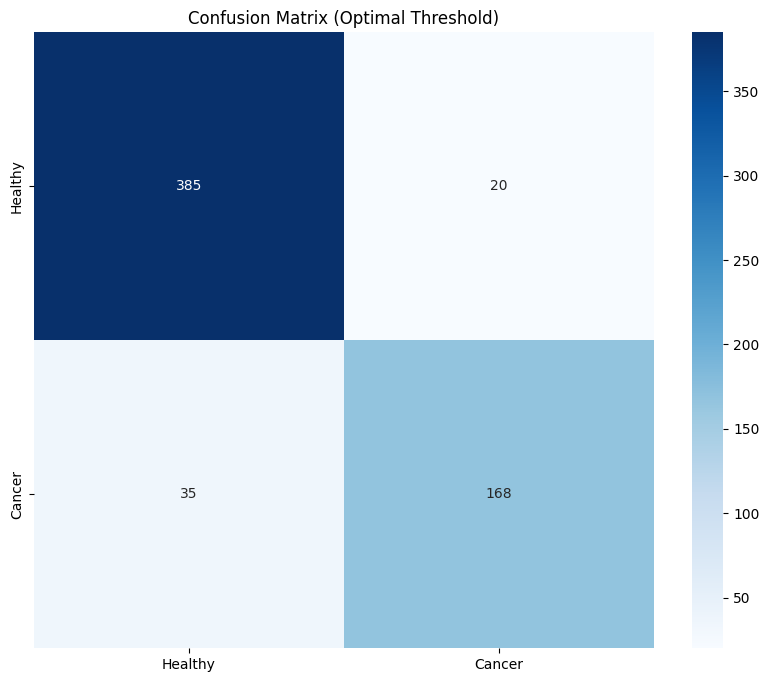

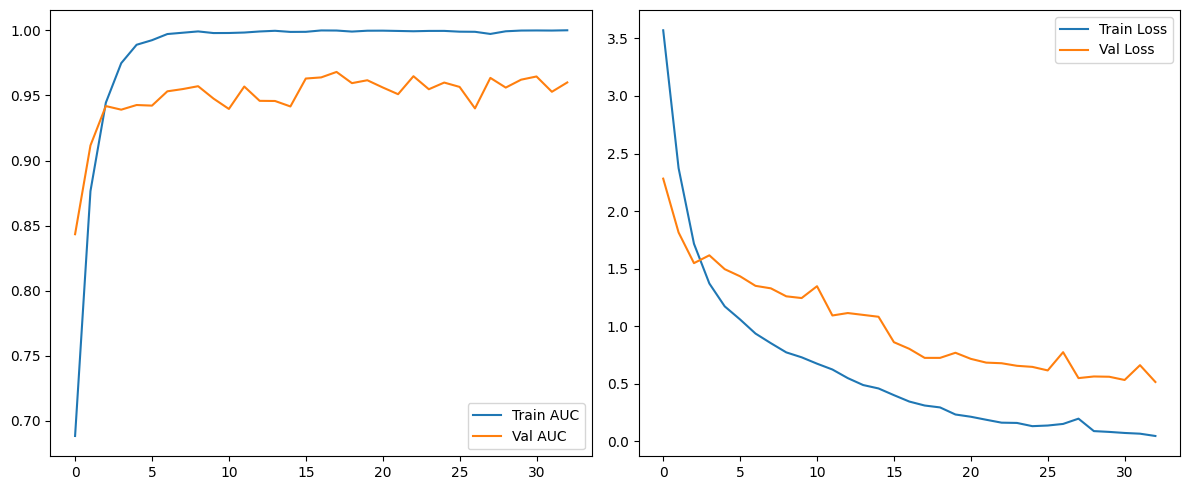

In [21]:
print("\nCLINICAL PERFORMANCE")
print(classification_report(y_test, y_pred_optimal, 
                          target_names=['Healthy', 'Cancer']))
print(f"Optimal Threshold: {optimal_threshold:.3f}")

# Confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred_optimal), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Cancer'],
            yticklabels=['Healthy', 'Cancer'])
plt.title('Confusion Matrix (Optimal Threshold)')
plt.show()

# Learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Save the trained model
model.save("lung_cancer_model.keras")

print("Model saved successfully!")

Model saved successfully!
